In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import inv
from numpy import identity as I

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PolynomialFeatures

np.set_printoptions(sign = ' ')

In [2]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_svm(X_train, y_train, clf):
    fig, ax = plt.subplots()
    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c = y_train, cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')
    plt.show()


In [3]:
def L2_dist(x1, x2):
    return np.sqrt(np.sum(np.square(x1 - x2)))

## Quadratic Programming Incremental SVM

In [4]:
class online_svm_qp():

    def __init__(self, threshold = None):
        
        self.bias = None
        self.weights = None
        self.X_retained = None
        self.y_retained = None

        self.support_vec_ids = None
        self.threshold = threshold
        self.clf = None # for plotting

    def fit(self, X, y):
        """
        inputs  : X_init (numpy array)
                  y_init (numpy vector)
        outputs : None 
        """
        self.clf = SVC(kernel = 'linear')
        self.clf.fit(X, y)
        self.bias = self.clf.intercept_[0] 
        self.weights = self.clf.coef_[0]
        self.support_vec_ids = set(self.clf.support_)
        self.update_candidates(X, y)
        

    def distance_DB(self, x, y):
        """
        inputs  : x (numpy vector)
                  y (int: 1 or -1)
        outputs : distance to hyperplane
        """
        assert (y == -1) or (y == 1) # should not pass 0
        fx = np.dot(self.weights, x) + self.bias 
        return y * (fx) / np.linalg.norm(self.weights)


    def update_candidates(self, X, y):
        """
        inputs  : X (numpy array)
                  y (numpy vector)
        outputs : None
        """
        # centroids
        pos_centroid = np.mean(X[np.where(y == 1)], axis = 0)
        neg_centroid = np.mean(X[np.where(y == 0)], axis = 0)

        # distance to closest svec
        R_pos = R_neg = 1e10
        for i in self.support_vec_ids: 
            
            pos_dist = L2_dist(pos_centroid, X[i])
            neg_dist = L2_dist(neg_centroid, X[i])

            R_pos = min(pos_dist, R_pos)
            R_neg = min(neg_dist, R_neg)

        # centoids to hyperplane distances
        R0_pos = self.distance_DB(pos_centroid, 1)
        R0_neg = self.distance_DB(neg_centroid, -1)

        # logging min_pairwise_dist (only searching among svecs)
        svec_ids_array = np.array(list(self.support_vec_ids))
        X_svecs_pos = X[svec_ids_array, :][y[svec_ids_array] == 1]
        X_svecs_neg = X[svec_ids_array, :][y[svec_ids_array] == 0]

        self.min_pairwise_dist = 1e5
        for x_pos in X_svecs_pos:
            for x_neg in X_svecs_neg:
                self.min_pairwise_dist = min(self.min_pairwise_dist, L2_dist(x_pos, x_neg))

        # selecting CSVs
        self.X_retained = []
        self.y_retained = []
        for i in range(X.shape[0]):

            if i in self.support_vec_ids: 
                self.X_retained.append(X[i])
                self.y_retained.append(y[i])

            else:
                if y[i] == 1:
                    d = L2_dist(X[i], pos_centroid)
                else:
                    d = L2_dist(X[i], neg_centroid)                

                if not isinstance(self.threshold, float):
                    if y[i] == 1:
                        if (d >= R_pos) and (self.distance_DB(X[i], 1) <= R0_pos):
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])
                    else:
                        if (d >= R_neg) and (self.distance_DB(X[i], -1) <= R0_neg):
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])

                else:                     
                    
                    L = 1 / np.linalg.norm(self.weights) # 1/2 margin distance
                    
                    if y[i] == 1:
                        t = d / (d + R_pos) + L / (L + self.distance_DB(X[i], 1)) - 1
                        if -self.threshold < t < self.threshold:
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])
                    else:
                        t = d / (d + R_neg) + L / (L + self.distance_DB(X[i], -1)) - 1
                        if -self.threshold < t < self.threshold:
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])
      
        self.X_retained = np.array(self.X_retained)
        self.y_retained = np.array(self.y_retained)

    def update(self, X, y, tol = 1e-3):

        if X.ndim == 1:
            X = np.expand_dims(X, axis = 0)
            y = np.expand_dims(y, axis = 0)

        X_violations = []
        y_violations = []
        for i in range(X.shape[0]):
            if y[i] == 1:
                if (self.distance_DB(X[i], 1) < 1 - tol):
                    X_violations.append(X[i])
                    y_violations.append(y[i])

            else:
                if (self.distance_DB(X[i], -1) < 1 - tol):
                    X_violations.append(X[i])
                    y_violations.append(y[i])

        if X_violations == []:
            return 

        else:

            self.X_retained = np.vstack((self.X_retained, X_violations))
            self.y_retained = np.append(self.y_retained, y_violations)

            self.fit(self.X_retained, self.y_retained)



## Least Squares Incremental SVM

In [5]:
class online_lssvm():

    def __init__(self, rho = 0.001, degree = None):
        
        self.C = None
        self.rho = rho
        self.bias = None
        self.weights = None
        self.degree = degree

    def fit(self, X, y):
 
        if isinstance(self.degree, int):
            X = PolynomialFeatures(self.degree).fit_transform(X)

        y[y == 0] = -1 # labels must be -1 or 1
        X = np.c_[np.ones((X.shape[0], 1)), X] # appending 1s

        self.C = X.T @ inv(X @ X.T + self.rho * I(X.shape[0])) @ X # p X p
        weight_vec = (inv(X.T @ X + self.rho * I(X.shape[1])) @ X.T) @ y 
        self.bias, self.weights = weight_vec[0], weight_vec[1:]
    
        print('size of C is ', self.C.shape)

    def update(self, X, y):

        if X.ndim == 1:
            X = np.expand_dims(X, axis = 0)
            y = np.expand_dims(y, axis = 0)

        if isinstance(self.degree, int):
            X = PolynomialFeatures(self.degree).fit_transform(X)

        r = self.rho
        N = X.shape[0]
        p = self.C.shape[0]
        
        y[y == 0] = -1 # labels must be -1 or 1
        X = np.c_[np.ones((X.shape[0], 1)), X]

        self.C += (self.C - I(p)) @ X.T @ inv(r * I(N) - X @ (self.C - I(p)) @ X.T) @ X @ (self.C - I(p))
        weight_vec = np.insert(self.weights, 0, self.bias)
        weight_vec += (self.C - I(p)) @ X.T @ inv(r * I(N) - X @ (self.C - I(p)) @ X.T) @ (X @ weight_vec - y)
        self.bias, self.weights = weight_vec[0], weight_vec[1:]

    def predict(self, X):
        
        if isinstance(self.degree, int):
            X = PolynomialFeatures(self.degree).fit_transform(X)

        X = np.c_[np.ones((X.shape[0], 1)), X]
        weight_vec = np.insert(self.weights, 0, self.bias)
        return np.where(X @ weight_vec >= 0, 1, 0)



## Stochastic Gradient Descent SVM

In [6]:
class online_svm_sgd(SGDClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, X, y):
        super().fit(X, y)
        self.weights = self.coef_[0]
        self.bias = self.intercept_[0]

    def update(self, X, y):

        if X.ndim == 1:
            X = np.expand_dims(X, axis = 0)
            y = np.expand_dims(y, axis = 0)

        super().partial_fit(X, y)
        self.weights = self.coef_[0]
        self.bias = self.intercept_[0]


## Updating piece by piece

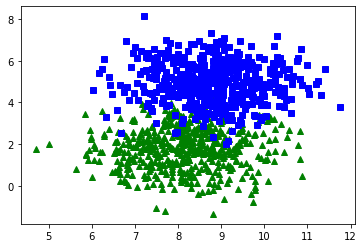

In [7]:
X, y = datasets.make_blobs(n_samples = 1000, centers = 2, n_features = 2, center_box = (0, 10), random_state = 61)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [27]:
X_init, y_init = X[:500, :], y[:500]
X_u1, y_u1 = X[500:700, :], y[500: 700]
X_u2, y_u2 = X[700:, :], y[700:]

In [28]:
# testing for weird patterns of updates
# X_init, y_init = X[X[:, 0] > 5.5, :], y[X[:, 0] > 5.5]
# X_u1, y_u1 = X[(X[:, 0] < 5.5) & (X[:, 0] > 4), :], y[(X[:, 0] < 5.5) & (X[:, 0] > 4)]
# X_u2, y_u2 = X[X[:, 0] < 4, :], y[X[:, 0] < 4]

In [43]:
qp_svm = online_svm_qp()
s = time.time()
qp_svm.fit(X_init, y_init)
print('qp_svm     :', time.time() - s, 'seconds')

X_a, y_a = X_init, y_init
ridge_svm = online_lssvm(1e-6) 
s = time.time()
ridge_svm.fit(X_a, y_a.copy())
print('ridge svm  :', time.time() - s, 'seconds')

# sgd_svm = SGDClassifier()
sgd_svm = online_svm_sgd()
s = time.time()
sgd_svm.fit(X_a, y_a.copy())
print('sgd svm    :', time.time() - s, 'seconds')

attacker = SVC(kernel = 'linear')
s = time.time()
attacker.fit(X_a, y_a)
print('attacker   :', time.time() - s, 'seconds', end = "\n\n")

print('qp svm     : weights = ', np.round(qp_svm.weights, 4), '; bias = ', np.round(qp_svm.bias, 4))
print('attacker   : weights = ', np.round(attacker.coef_[0], 4), '; bias = ', np.round(attacker.intercept_[0], 4))
print('ridge svm  : weights = ', np.round(ridge_svm.weights, 4), '; bias = ', np.round(ridge_svm.bias, 4))
print('sgd svm    : weights = ', np.round(sgd_svm.weights, 4), '; bias = ', np.round(sgd_svm.bias, 4))

qp_svm     : 0.001999378204345703 seconds
size of C is  (3, 3)
ridge svm  : 0.0 seconds
sgd svm    : 0.0020036697387695312 seconds
attacker   : 0.0020079612731933594 seconds

qp svm     : weights =  [ 0.604   0.7232] ; bias =  -4.4926
attacker   : weights =  [ 0.604   0.7232] ; bias =  -4.4926
ridge svm  : weights =  [ 0.4184  0.3395] ; bias =  -2.8442
sgd svm    : weights =  [-29.7003  74.4832] ; bias =  -9.9505


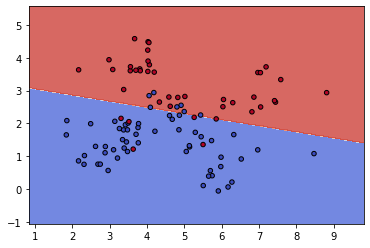

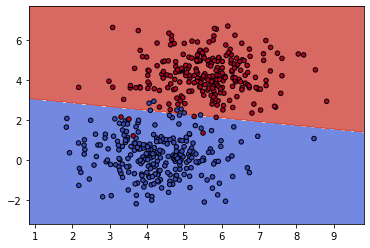

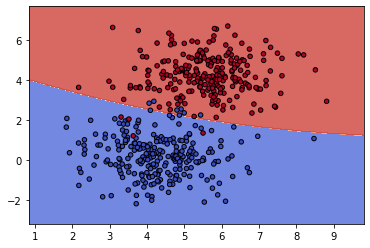

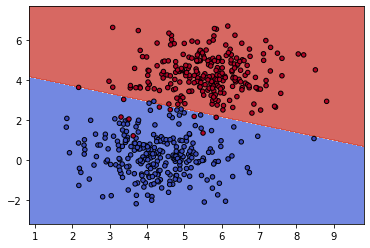

In [30]:
plot_decision_svm(qp_svm.X_retained, qp_svm.y_retained, qp_svm.clf)
plot_decision_svm(X_a, y_a, attacker)
plot_decision_svm(X_a, y_a, ridge_svm)
plot_decision_svm(X_a, y_a, sgd_svm)

In [31]:
s = time.time()
qp_svm.update(X_u1, y_u1)
print('qp_svm     :', time.time() - s, 'seconds')

s = time.time()
ridge_svm.update(X_u1, y_u1.copy())
print('ridge svm  :', time.time() - s, 'seconds')

s = time.time()
sgd_svm.update(X_u1, y_u1)
print('sgd svm    :', time.time() - s, 'seconds')

X_a = np.vstack((X_a, X_u1))
y_a = np.append(y_a, y_u1)

s = time.time()
attacker.fit(X_a, y_a)
print('attacker   :', time.time() - s, 'seconds', end = "\n\n")

print('qp svm     : weights = ', np.round(qp_svm.weights, 4), '; bias = ', np.round(qp_svm.bias, 4))
print('attacker   : weights = ', np.round(attacker.coef_[0], 4), '; bias = ', np.round(attacker.intercept_[0], 4))
print('ridge svm  : weights = ', np.round(ridge_svm.weights, 4), '; bias = ', np.round(ridge_svm.bias, 4))
print('ridge svm  : weights = ', np.round(sgd_svm.weights, 4), '; bias = ', np.round(sgd_svm.bias, 4))

qp_svm     : 0.008992671966552734 seconds
ridge svm  : 0.004981279373168945 seconds
sgd svm    : 0.000989675521850586 seconds
attacker   : 0.0020003318786621094 seconds

qp svm     : weights =  [ 0.3966  2.008 ] ; bias =  -6.5006
attacker   : weights =  [ 0.3966  2.008 ] ; bias =  -6.5006
ridge svm  : weights =  [-0.8257  0.2407  0.3581 -0.0137  0.006  -0.0044] ; bias =  -0.8258
ridge svm  : weights =  [ 13.9845  36.2014] ; bias =  -157.203


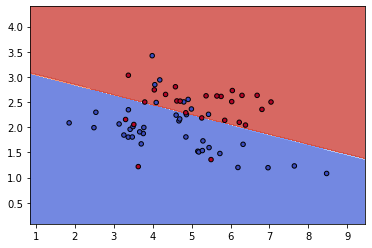

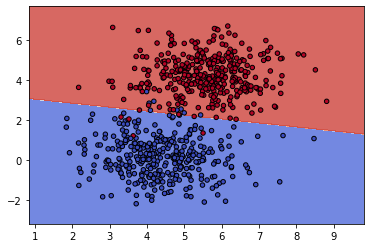

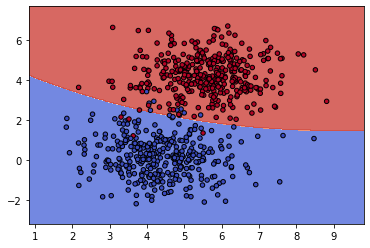

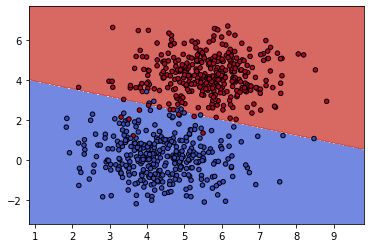

In [32]:
plot_decision_svm(qp_svm.X_retained, qp_svm.y_retained, qp_svm.clf)
plot_decision_svm(X_a, y_a, attacker)
plot_decision_svm(X_a, y_a, ridge_svm)
plot_decision_svm(X_a, y_a, sgd_svm)

In [33]:
s = time.time()
qp_svm.update(X_u2, y_u2)
print('qp_svm     :', time.time() - s)

s = time.time()
ridge_svm.update(X_u2, y_u2.copy())
print('ridge svm  :', time.time() - s)

s = time.time()
sgd_svm.update(X_u2, y_u2)
print('sgd svm    :', time.time() - s)

X_a = np.vstack((X_a, X_u2))
y_a = np.append(y_a, y_u2)

s = time.time()
attacker.fit(X_a, y_a)
print('attacker   :', time.time() - s, end = "\n\n")

print('qp svm     : weights = ', np.round(qp_svm.weights, 4), '; bias = ', np.round(qp_svm.bias, 4))
print('attacker   : weights = ', np.round(attacker.coef_[0], 4), '; bias = ', np.round(attacker.intercept_[0], 4))
print('ridge svm  : weights = ', np.round(ridge_svm.weights, 4), '; bias = ', np.round(ridge_svm.bias, 4))
print('ridge svm  : weights = ', np.round(sgd_svm.weights, 4), '; bias = ', np.round(sgd_svm.bias, 4))

qp_svm     : 0.014002084732055664
ridge svm  : 0.012001991271972656
sgd svm    : 0.0010008811950683594
attacker   : 0.003000974655151367

qp svm     : weights =  [ 0.4578  1.897 ] ; bias =  -6.5192
attacker   : weights =  [ 0.4579  1.9259] ; bias =  -6.5835
ridge svm  : weights =  [-0.7829  0.2026  0.355  -0.01    0.004  -0.0014] ; bias =  -0.783
ridge svm  : weights =  [ 14.2121  35.026 ] ; bias =  -157.2037


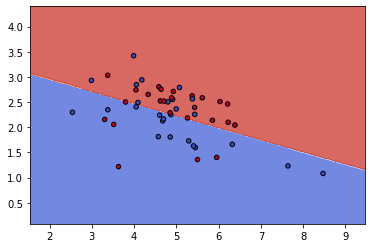

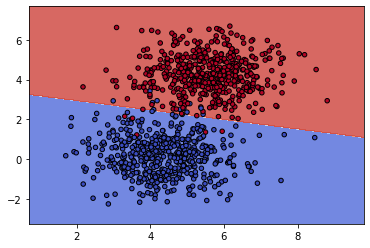

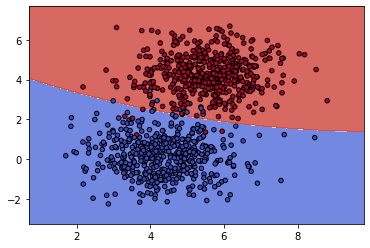

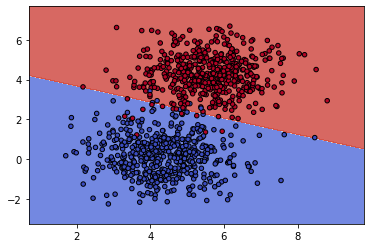

In [34]:
plot_decision_svm(qp_svm.X_retained, qp_svm.y_retained, qp_svm.clf)
plot_decision_svm(X_a, y_a, attacker)
plot_decision_svm(X_a, y_a, ridge_svm)
plot_decision_svm(X_a, y_a, sgd_svm)

In [35]:
from pympler import asizeof
print('qp_svm    : ', str(asizeof.asizeof(qp_svm) / 1e6) + ' mb')
print('ridge_svm : ', str(asizeof.asizeof(ridge_svm) / 1e6) + ' mb') 
print('sgd_svm   : ', str(asizeof.asizeof(sgd_svm) / 1e6) + ' mb') 

qp_svm    :  0.012176 mb
ridge_svm :  0.001288 mb
sgd_svm   :  0.003752 mb


In [36]:
print(f'qp_svm    : ', accuracy_score(qp_svm.clf.predict(X_a), y_a))
print(f'ridge svm : ', accuracy_score(ridge_svm.predict(X_a), y_a))
print(f'sgd svm   : ', accuracy_score(sgd_svm.predict(X_a), y_a))
print(f'attacker  : ', accuracy_score(attacker.predict(X_a), y_a))

qp_svm    :  0.983
ridge svm :  0.982
sgd svm   :  0.98
attacker  :  0.983


## Testing point by point

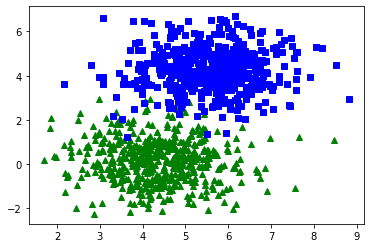

In [37]:
X, y = datasets.make_blobs(n_samples = 1000, centers = 2, n_features = 2, center_box = (0, 10), random_state = 2)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [38]:
qp_svm = online_svm_qp()
s = time.time()
X_init, y_init = X[:5, :], y[:5] # must have both classes in y_init
qp_svm.fit(X_init, y_init) 

for i in range(100, 1000):
    qp_svm.update(X[i, :], y[i])

print('qp_svm     :', time.time() - s, 'seconds')
print('qp svm     : weights = ', np.round(qp_svm.weights, 4), '; bias = ', np.round(qp_svm.bias, 4))
print('qp_svm     :', accuracy_score(qp_svm.clf.predict(X), y))

qp_svm     : 0.27507495880126953 seconds
qp svm     : weights =  [ 0.4449  1.6106] ; bias =  -5.7268
qp_svm     : 0.982


In [39]:
ridge_svm = online_lssvm()
s = time.time()
X_init, y_init = X[:5, :], y[:5]
ridge_svm.fit(X_init, y_init.copy())

for i in range(100, 1000):
    ridge_svm.update(X[i, :], y[i].copy())

print('ridge svm  :', time.time() - s, 'seconds')
print('ridge svm  : weights = ', np.round(ridge_svm.weights, 4), '; bias = ', np.round(ridge_svm.bias, 4))
print('ridge svm  :', accuracy_score(ridge_svm.predict(X), y))

size of C is  (3, 3)
ridge svm  : 0.10954618453979492 seconds
ridge svm  : weights =  [ 0.1178  0.3655] ; bias =  -1.3908
ridge svm  : 0.981


In [40]:
sgd_svm = online_svm_sgd()
s = time.time()
X_init, y_init = X[:5, :], y[:5]
sgd_svm.fit(X_init, y_init)

for i in range(100, 1000):
    sgd_svm.update(X[i, :], y[i])

print('sgd svm    :', time.time() - s, 'seconds')
print('sgd svm    : weights = ', np.round(sgd_svm.weights, 4), '; bias = ', np.round(sgd_svm.bias, 4))
print('sgd svm    :', accuracy_score(sgd_svm.predict(X), y))

sgd svm    : 0.1366887092590332 seconds
sgd svm    : weights =  [-16.9412  99.4572] ; bias =  -123.0734
sgd svm    : 0.966


In [41]:
attacker = SVC(kernel = 'linear')
s = time.time()
attacker.fit(X, y)

print('attacker   :', time.time() - s, 'seconds')
print('attacker   : weights = ', np.round(attacker.coef_[0], 4), '; bias = ', np.round(attacker.intercept_[0], 4))
print('attacker   :', accuracy_score(attacker.predict(X), y))

attacker   : 0.0029981136322021484 seconds
attacker   : weights =  [ 0.4579  1.9259] ; bias =  -6.5835
attacker   : 0.983


In [42]:
print('qp_svm    : ', str(asizeof.asizeof(qp_svm) / 1e6) + ' mb')
print('ridge_svm : ', str(asizeof.asizeof(ridge_svm) / 1e6) + ' mb') 
print('sgd_svm   : ', str(asizeof.asizeof(sgd_svm) / 1e6) + ' mb') 

qp_svm    :  0.011728 mb
ridge_svm :  0.000904 mb
sgd_svm   :  0.003752 mb
